In [25]:
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy import stats
import glob
from scipy.stats import ks_2samp, kstest
import seaborn as sns
import pandas as pd
%matplotlib inline

In [2]:
def load_summary(filename):
    dtype=[('minr', 'f8'),
           ('maxr', 'f8'), 
           ('ca_ratio', 'f8'),
           ('ba_ratio', 'f8'),
           ('a', 'f8'),
           ('center', 'f8'),
           ('width', 'f8'),
           ('mu', 'f8')]
    summary = np.loadtxt(filename, dtype=dtype)    
    return summary

In [3]:
def load_experiment(input_path="../data/mstar_selected_summary/vmax_sorted/", fixed_number=False, full_data=False):
    files = glob.glob(input_path+"M31_group_*")
    group_id = []
    for f in files:
        i = int(f.split("_")[-5])
        if i not in group_id:
            group_id.append(i)
    print(group_id, len(group_id))

    n_groups = len(group_id)

    if fixed_number:
        n_iter = np.arange(5)
    else:
        n_iter = np.arange(11,16)
    
    fields = ['width','mu', 'a', 'ba_ratio', 'ca_ratio']
    M31_all = {}
    MW_all = {}
    if not full_data:
        for field in fields:
            M31_all[field] = np.ones(n_groups)
            MW_all[field] = np.ones(n_groups)
            M31_all[field+'_sigma'] = np.ones(n_groups)
            MW_all[field+'_sigma'] = np.ones(n_groups)
        
            M31_all[field+'_random'] = np.ones(n_groups)
            MW_all[field+'_random'] = np.ones(n_groups)
            M31_all[field+'_random_sigma'] = np.ones(n_groups)
            MW_all[field+'_random_sigma'] = np.ones(n_groups)
    else:
        for field in fields:
            M31_all[field] = np.empty((0))
            MW_all[field] = np.empty((0))
            M31_all[field+'_random'] = np.empty((0))
            MW_all[field+'_random'] = np.empty((0))
           

    for g in range(n_groups):

        MW_summary = {}
        M31_summary = {}
    
        for i in n_iter:
            if fixed_number:
                filename_MW = os.path.join(input_path,"MW_group_{}_nmax_{}_iter_{}.dat".format(group_id[g], 11, i))
                filename_M31 = os.path.join(input_path,"M31_group_{}_nmax_{}_iter_{}.dat".format(group_id[g],11, i))
            else:
                filename_MW = os.path.join(input_path,"MW_group_{}_nmax_{}_iter_{}.dat".format(group_id[g], i, 0))
                filename_M31 = os.path.join(input_path,"M31_group_{}_nmax_{}_iter_{}.dat".format(group_id[g], i, 0))

            MW_summary[i] = load_summary(filename_MW)
            M31_summary[i] = load_summary(filename_M31)
    
        
        for field in fields:
            a = np.empty((0))
            b = np.empty((0))
            a_random = np.empty((0))
            b_random = np.empty((0))
        
            for i in n_iter:
                data = M31_summary[i]
                a = np.append(a, data[field][0])
                a_random = np.append(a_random, data[field][1:101])
        
                data = MW_summary[i]
                b = np.append(b, data[field][0])
                b_random = np.append(b_random, data[field][1:101])
                #print('a_random {} iter: {} {}'.format(field, i, a_random))
                
            if not full_data:
                M31_all[field][g] = np.average(a)
                MW_all[field][g] = np.average(b)
                M31_all[field+'_sigma'][g] = np.std(a)
                MW_all[field+'_sigma'][g] = np.std(b)
                M31_all[field+'_random'][g] = np.average(a_random)
                MW_all[field+'_random'][g] = np.average(b_random)
                M31_all[field+'_random_sigma'][g] = np.std(a_random)
                MW_all[field+'_random_sigma'][g] = np.std(b_random)
            else:
                M31_all[field] = np.append(M31_all[field], a)
                MW_all[field] = np.append(MW_all[field], b)
                M31_all[field+'_random'] = np.append(M31_all[field+'_random'], a_random)
                MW_all[field+'_random'] = np.append(MW_all[field+'_random'], b_random)
                
    return M31_all, MW_all

In [14]:
in_path = "../data/elvis_mstar_selected_summary/vmax_sorted/"
M31_sim_vmax_sorted, MW_sim_vmax_sorted = load_experiment(input_path=in_path, fixed_number=False)


in_path = "../data/obs_summary/vmag_random/"
M31_obs_vmag_random_full, MW_obs_vmag_random_full = load_experiment(input_path=in_path, fixed_number=True, full_data=True)

in_path = "../data/obs_summary/vmag_sorted/"
M31_obs_vmag_sorted_full, MW_obs_vmag_sorted_full = load_experiment(input_path=in_path, fixed_number=False, full_data=True)

in_path = "../data/obs_summary/vmag_random/"
M31_obs_vmag_random, MW_obs_vmag_random = load_experiment(input_path=in_path, fixed_number=True, full_data=False)

in_path = "../data/obs_summary/vmag_sorted/"
M31_obs_vmag_sorted, MW_obs_vmag_sorted = load_experiment(input_path=in_path, fixed_number=False, full_data=False)



[0, 10, 11, 1, 2, 3, 4, 5, 6, 7, 8, 9] 12
[0] 1
[0] 1
[0] 1
[0] 1


In [15]:
fields = ['width', 'ca_ratio', 'ba_ratio']
n_fields = len(fields)
data = np.zeros((2*n_fields, len(M31_sim_vmax_sorted['width'])))
data_obs = np.zeros((2*n_fields, 1))

for i in range(n_fields):
    field = fields[i]
    x_sim = (M31_sim_vmax_sorted[field] - M31_sim_vmax_sorted[field+'_random'])/M31_sim_vmax_sorted[field+'_random_sigma']
    y_sim = (MW_sim_vmax_sorted[field] - MW_sim_vmax_sorted[field+'_random'])/MW_sim_vmax_sorted[field+'_random_sigma']
    data[i,:] = x_sim[:]
    data[i+n_fields,:] = y_sim[:]
    
    x_obs = (M31_obs_vmag_sorted[field] - M31_obs_vmag_sorted[field+'_random'])/M31_obs_vmag_sorted[field+'_random_sigma']
    y_obs = (MW_obs_vmag_sorted[field] - MW_obs_vmag_sorted[field+'_random'])/MW_obs_vmag_sorted[field+'_random_sigma']
    data_obs[i,:] = x_obs[:]
    data_obs[i+n_fields,:] = y_obs[:]


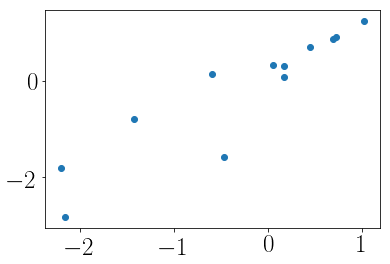

In [16]:
plt.scatter(data[1,:], data[0,:])

[[ 1.62379515  1.28517739  0.73266503]
 [ 1.28517739  1.21619865  0.35099935]
 [ 0.73266503  0.35099935  0.66882559]]
[[ 0.474712    0.69517628 -0.12711674]
 [ 0.69517628  1.48614376 -0.69523646]
 [-0.12711674 -0.69523646  0.60727057]]
[[ 0.07928664  0.10689874  0.06519665]
 [ 0.00894519  0.15109127 -0.07474071]
 [ 0.10295017 -0.00331069  0.15148833]]
[-0.19491452 -0.30181567 -0.21619195 -0.34788154 -0.7644001  -0.11353613]


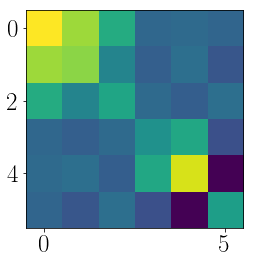

In [17]:
data_cov = np.cov(data)
data_mean = np.mean(data, axis=1)#np.zeros(2*n_fields)
plt.imshow(data_cov.T)
print(data_cov[0:3, 0:3])
print(data_cov[3:6, 3:6])
print(data_cov[0:3, 3:6])
print(data_mean)

In [34]:
data_random = np.random.multivariate_normal(data_mean, data_cov, size=1000)

In [19]:
def plot_correlations(offset=0, title='ranked'):
    title = {0:'M31 correlations', 3:'MW correlations'}
    name = {0:'M31', 3:'MW'}
    plt.figure(figsize=(18,6))
    plt.rc('text', usetex=True,)
    plt.rc('font', family='serif', size=25)

    plt.subplot(131)
    plt.scatter(data_random[:,0+offset], data_random[:,1+offset], c='black', s=0.1, alpha=0.5, label='Gaussian')
    plt.scatter(data[0+offset,:], data[1+offset,:], c='black', s=50, label='Simulations')
    plt.scatter(data_obs[0+offset,:], data_obs[1+offset,:], c='black', s=1000.0,marker='*', label='Observations')
    plt.xlim([-3,3])
    plt.ylim([-3,3])
    plt.xlabel('Normalized width')
    plt.ylabel('Normalized c/a')
    plt.grid()
    plt.xticks(np.linspace(-3,3,7))
    plt.yticks(np.linspace(-3,3,7))
    plt.legend(loc=2, prop={'size': 20})



    plt.subplot(132)
    plt.scatter(data_random[:,0+offset], data_random[:,2+offset], c='black', s=0.1, alpha=0.5)
    plt.scatter(data[0+offset,:], data[2+offset,:], c='black', s=50)
    plt.scatter(data_obs[0+offset,:], data_obs[2+offset,:], c='black', s=1000.0,marker='*')
    plt.xlim([-3,3])
    plt.ylim([-3,3])
    plt.xlabel('Normalized width')
    plt.ylabel('Normalized b/a')
    plt.grid()
    plt.xticks(np.linspace(-3,3,7))
    plt.yticks(np.linspace(-3,3,7))
    plt.title(title[offset])

    plt.subplot(133)
    plt.scatter(data_random[:,1+offset], data_random[:,2+offset], c='black', s=0.1, alpha=0.5)
    plt.scatter(data[1+offset,:], data[2+offset,:], c='black', s=50)
    plt.scatter(data_obs[1+offset,:], data_obs[2+offset,:], c='black', s=1000.0,marker='*')
    plt.xlim([-3,3])
    plt.ylim([-3,3])
    plt.xlabel('Normalized c/a')
    plt.ylabel('Normalized b/a')
    plt.grid()
    plt.xticks(np.linspace(-3,3,7))
    plt.yticks(np.linspace(-3,3,7))

    plt.tight_layout()
    filename = "../paper/correlations_{}.pdf".format(name[offset], title)
    plt.savefig(filename, bbox_inches='tight')

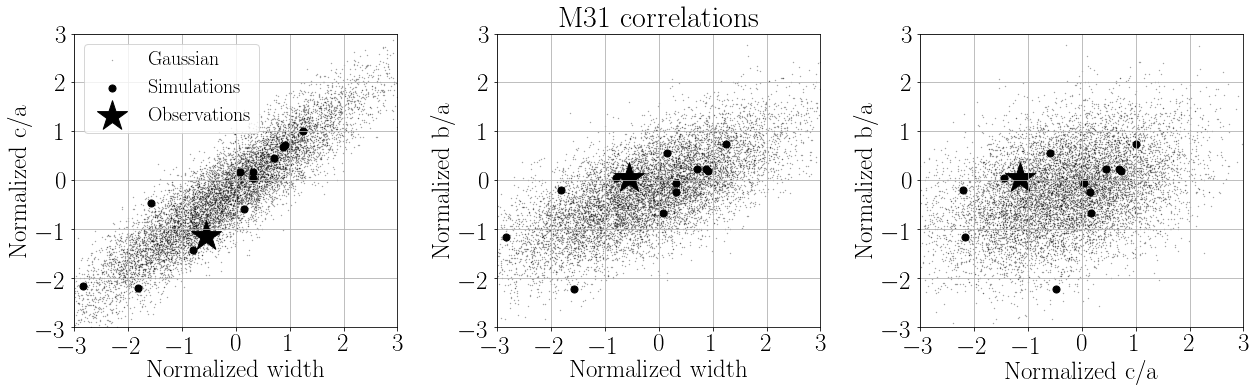

In [20]:
plot_correlations(offset=0)

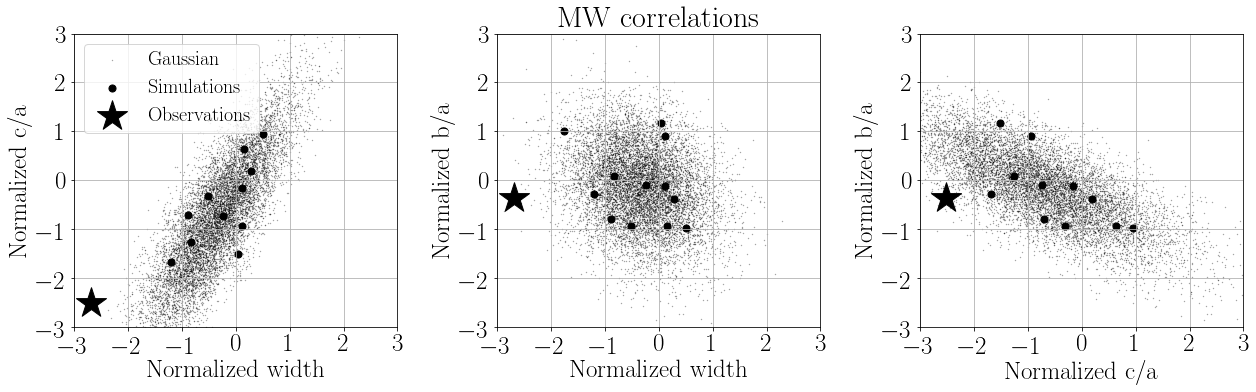

In [21]:
plot_correlations(offset=3)

In [22]:
def number_LG(n_sample=20):
    n_try = 10000
    n_out_list = np.ones(n_try)
    for i in range(n_try):
        data_random = np.random.multivariate_normal(data_mean, data_cov, size=n_sample)
        data_r_abs = np.abs(data_random)
        in_peak = (data_r_abs[:,0]< 2) & (data_r_abs[:,1]<2) & (data_r_abs[:,2]<2) &\
         (data_r_abs[:,3]< 2) & (data_r_abs[:,4]<2) & (data_r_abs[:,5]<2)
        out_peak = (data_r_abs[:,0]< 2) & (data_r_abs[:,1]<2) & (data_r_abs[:,2]<2) &\
         (data_random[:,3]< -2) & (data_random[:,4]<-2) & (data_r_abs[:,5]<2)
        n_in=np.count_nonzero(in_peak)
        n_out=np.count_nonzero(out_peak)
        n_out_list[i] = n_out
    return n_out_list

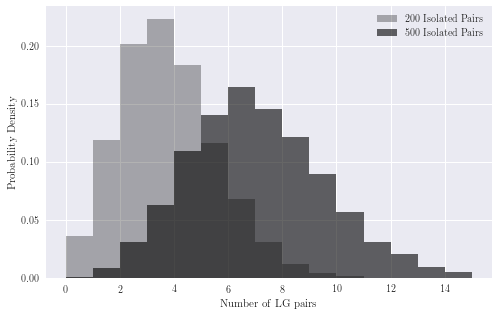

In [37]:
plt.figure(figsize=(8,5))
plt.rc('text', usetex=True,)
plt.rc('font', family='serif', size=25)

n_out_list = number_LG(n_sample=500)
a = plt.hist(n_out_list, bins=np.linspace(0,15,16), 
             normed=True, label='200 Isolated Pairs', alpha=0.3, color='black')

n_out_list = number_LG(n_sample=1000)
a = plt.hist(n_out_list, bins=np.linspace(0,15,16), 
             normed=True, label='500 Isolated Pairs', alpha=0.6, color='black')

plt.legend()
plt.xlabel('Number of LG pairs')
plt.ylabel('Probability Density')
a = plt.xticks(np.linspace(0,14,8))
filename = "../paper/expected_numbers.pdf"
plt.savefig(filename, bbox_inches='tight')

In [35]:
gauss_df = pd.DataFrame(data=data_random)

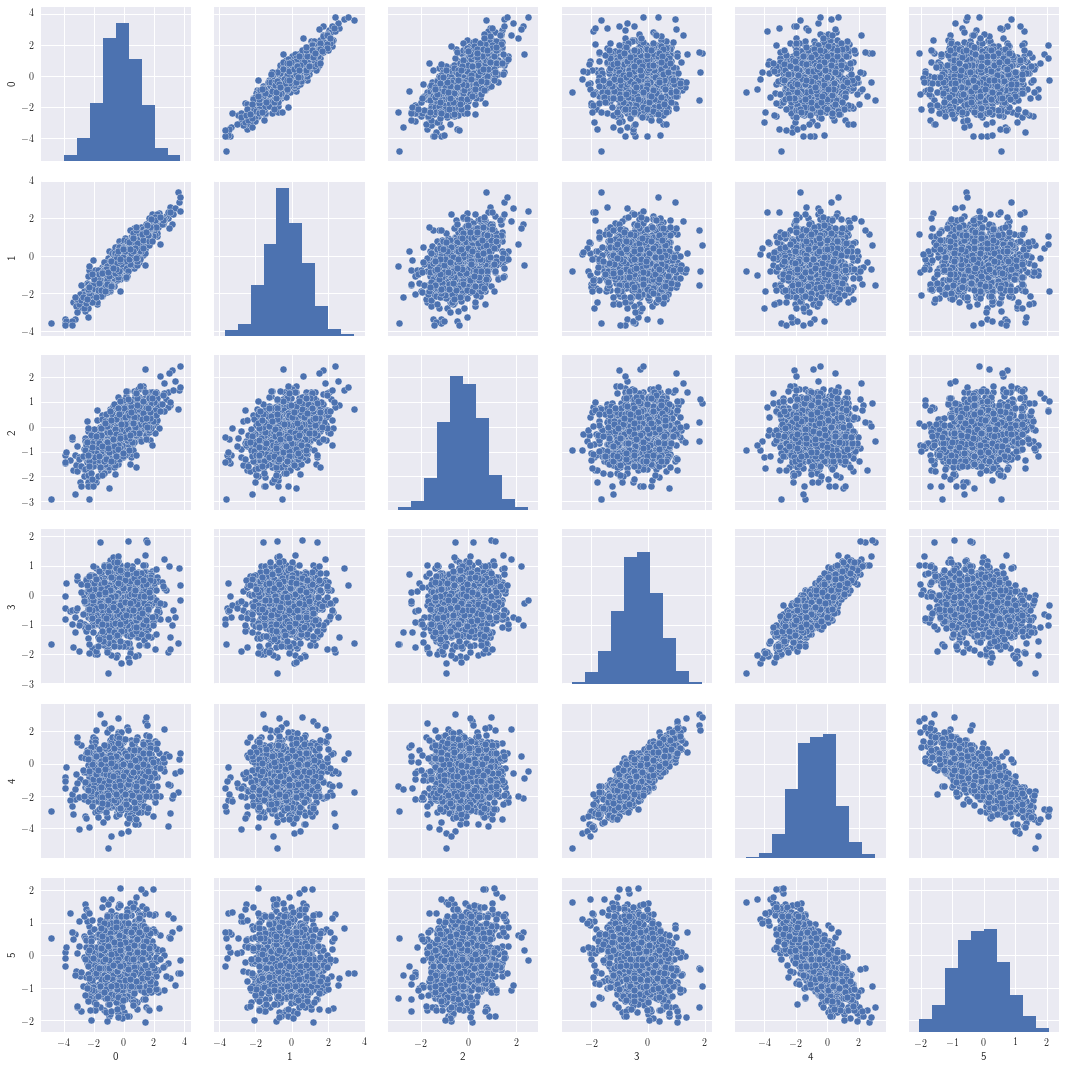

In [36]:
g = sns.pairplot(gauss_df, )

In [41]:
6, np.sqrt(6)

(6, 2.4494897427831779)